In [2]:
import pandas as pd
import ast
import json
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 폰트 경로로 FontProperties 객체 생성
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path)

pd.set_option('display.max_rows', None)


def read_parquet_from_gcs(file_names, gcs_prefix, key_path):
    dfs = {}
    for name in file_names:
        path = f"{gcs_prefix}/{name}.parquet"
        dfs[name] = pd.read_parquet(path, storage_options={"token": key_path})
    return dfs


file_list = [
    "device_properties",
    "hackle_events",
    "hackle_properties",
    "user_properties"
]

gcs_prefix = "gs://codeit-project/hackle"
key_path = "/home/leesh/codeit_project/codeit-project-docker/config/key.json"

dfs = read_parquet_from_gcs(file_list, gcs_prefix, key_path)



device_properties = dfs["device_properties"]


hackle_events = dfs["hackle_events"]


hackle_properties = dfs[ "hackle_properties"]


user_properties = dfs["user_properties"]


In [3]:
event_time = hackle_events.groupby('session_id').agg({'event_datetime':['min','max']})
event_time = event_time.reset_index()
event_time.head()

session_id      event_datetime  \
                                                        min   
0  000137bc-80de-4bb5-b61d-df7f217a4501 2023-07-21 14:23:33   
1  00025EE1-BA46-4853-8FDD-B991FABA328F 2023-07-22 23:30:09   
2  00039F52-AC9A-4474-A645-DFE225C56753 2023-08-08 13:40:38   
3  0004482B-03B0-4638-8C5A-C2E49C085C7F 2023-07-20 20:33:20   
4  0004F43C-3A7A-4DE4-A02B-55AFDF07E9AD 2023-07-26 18:53:38   

                       
                  max  
0 2023-07-21 14:23:33  
1 2023-07-30 19:40:37  
2 2023-08-08 13:40:38  
3 2023-07-20 20:33:20  
4 2023-08-07 20:31:49

In [4]:
# 1. session_id별 시작/종료 시각 구하기
event_time = hackle_events.groupby('session_id').agg({
    'event_datetime': ['min', 'max']
})

# 2. 인덱스 초기화
event_time = event_time.reset_index()

# 3. 이중 컬럼(flatten) 해제 및 이름 지정
event_time.columns = ['session_id', 'session_start', 'session_end']

# 4. 세션 지속시간 계산 (선택)
event_time['session_duration'] = event_time['session_end'] - event_time['session_start']

In [5]:
event_time.describe(include='all')

,session_id,session_start,session_end,session_duration
count,253616,253616,253616,253616
unique,253616,NaN,NaN,NaN
top,000137bc-80de-4bb5-b61d-df7f217a4501,NaN,NaN,NaN
freq,1,NaN,NaN,NaN
mean,NaN,2023-07-26 01:07:09.130000,2023-07-31 11:28:26.947000,5 days 10:21:17.817000
min,NaN,2023-07-18 00:00:00,2023-07-18 00:00:16,0 days 00:00:00
25%,NaN,2023-07-20 16:20:40.750000,2023-07-25 00:21:58,0 days 00:00:56
50%,NaN,2023-07-23 18:52:31,2023-08-01 00:52:05,0 days 13:16:45
75%,NaN,2023-07-29 23:45:51.250000,2023-08-06 20:02:59.250000,10 days 09:41:14
max,NaN,2023-08-10 23:59:54,2023-08-10 23:59:59,23 days 23:55:09


## 📊 세션 요약 통계 해석 (`event_time.describe()` 기준)

| 항목        | 설명 |
|-------------|------|
| `count`     | 총 253,616개의 세션 기록이 존재함 |
| `unique`    | `session_id`는 전부 고유함 (중복 없음) |
| `top` / `freq` | 가장 많이 나타난 `session_id`는 없음 (모두 1회 등장) |

---

### 🕒 session_start / session_end
- `min(session_start)` → 가장 이른 시작: **2023-07-18 00:00:00**
- `max(session_end)` → 가장 늦은 종료: **2023-08-10 23:59:59**

---

### ⏱ session_duration (세션 지속 시간)

- `mean` → 평균 세션 길이: **약 5.4일 (5일 10시간 21분)**
- `min` → 최소 세션 길이: **0초** (즉시 종료되었거나 단발성 진입)
- `25%` → 하위 25%의 세션은 **1분 미만**
- `50% (median)` → 절반의 세션은 **13시간 16분 이하**
- `75%` → 상위 25%의 세션은 **10일 이상**
- `max` → 가장 긴 세션: **약 24일 (23일 23시간 55분)**
- `std` → 표준편차는 **7.2일**, 긴 세션들이 분포를 크게 흔들고 있음

---

### 📌 요약 인사이트

- 평균은 길지만 중앙값은 짧음 → **긴 세션 소수 존재 (비대칭 분포)**
- `session_duration == 0`인 세션 존재 → **단발성 접근 / 로그 오류 가능성**
- 상위 25%는 10일 이상 접속 → **충성도 높은 유저군 존재 가능성**




**23년 7월 26일 ~ 23년 8월 10일까지의 데이터이므로 세션 지속은 다른 hackle데이터를 본다면 달라질 수 있을 것!**

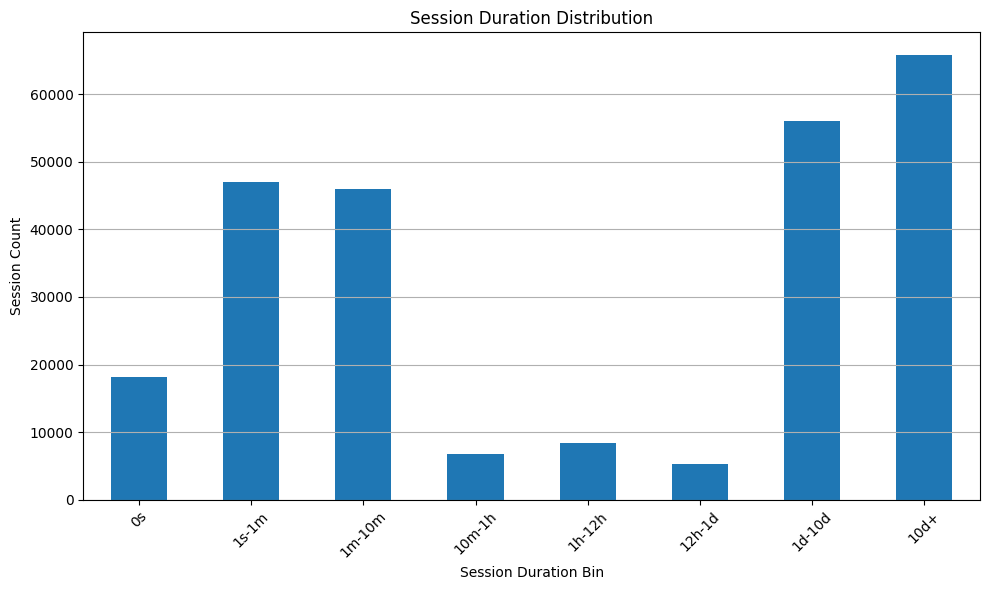

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. session_duration → 초 변환
event_time['duration_sec'] = event_time['session_duration'].dt.total_seconds()

# 2. bin 정의 (초 단위)
bins = [0, 1, 60, 600, 3600, 43200, 86400, 864000, float('inf')]
labels = [
    '0s',
    '1s-1m',
    '1m-10m',
    '10m-1h',
    '1h-12h',
    '12h-1d',
    '1d-10d',
    '10d+'
]

# 3. 구간 분류
event_time['duration_bin'] = pd.cut(event_time['duration_sec'], bins=bins, labels=labels, right=False)

# 4. 구간별 세션 수 집계
bin_counts = event_time['duration_bin'].value_counts().sort_index()

# 5. 시각화
plt.figure(figsize=(10, 6))
bin_counts.plot(kind='bar')
plt.title('Session Duration Distribution')
plt.xlabel('Session Duration Bin')
plt.ylabel('Session Count')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 📊 Session Duration Distribution 해석

세션 지속 시간을 여러 구간(bin)으로 나누어 세션 수를 시각화한 막대그래프입니다.

### ✅ x축 구간 설명

| 구간       | 설명                             |
|------------|----------------------------------|
| `0s`       | 시작과 동시에 종료된 세션 (0초)       |
| `1s–1m`    | 1초 이상 1분 미만                    |
| `1m–10m`   | 1분 이상 10분 미만                   |
| `10m–1h`   | 10분 이상 1시간 미만                  |
| `1h–12h`   | 1시간 이상 12시간 미만                |
| `12h–1d`   | 12시간 이상 1일 미만                  |
| `1d–10d`   | 1일 이상 10일 미만                   |
| `10d+`     | 10일 이상 지속된 세션 (장기 접속 또는 비정상 가능) |

---

### 🔍 주요 인사이트

- **1m–10m** 및 **1s–1m** 구간의 세션 수가 매우 많음  
  → 사용자 다수가 짧게 사용하고 이탈하는 패턴

- **10d+ (10일 이상)** 구간이 가장 많음  

- **중간 구간 (10m–1h, 1h–1d)**은 상대적으로 낮음  
  → 세션 분포가 양극화되어 있음 (짧거나 매우 긴 세션 중심)

---

### 🧠 해석 요약

- **짧은 세션**이 매우 많음 → 가볍게 사용하고 빠르게 이탈하는 유저군 존재
- **극단적으로 긴 세션**도 많음 → 유지형 사용자 또는 비정상 세션 가능
- **중간 체류 시간대는 적음** → 꾸준한 사용보다는 짧거나 장기 방치된 패턴

In [7]:
hackle_events.head()

,event_id,event_datetime,event_key,session_id,id,item_name,page_name,friend_count,votes_count,heart_balance,question_id
0,00000533-3f1c-4b3b-81f1-0c8f35754b4e,2023-07-18 19:40:17,$session_start,4OzYh3seq3VKytpSn5pvQkZNQii1,00000533-3f1c-4b3b-81f1-0c8f35754b4e,,,NaN,NaN,NaN,NaN
1,00000716-27e9-4e72-a602-d0ce61784b06,2023-07-18 21:07:24,click_question_open,8QXy31PQxbW9qLzq0Y1dhR8Ypm52,00000716-27e9-4e72-a602-d0ce61784b06,,,64.0,436.0,4830.0,NaN
2,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,2023-08-06 20:18:03,click_bottom_navigation_profile,6bcea65d-9f40-46fc-888c-700fe707483f,000007c8-68ce-40e6-9b1e-f0e34e8ff9cc,,,26.0,174.0,4729.0,NaN
3,00000981-5e2a-4111-993e-4f1891ad9a53,2023-08-05 01:46:10,view_shop,XVYNT6zfhFWqIg9omwg2AHDjTLx2,00000981-5e2a-4111-993e-4f1891ad9a53,,,61.0,44.0,142.0,NaN
4,00000a7a-ba72-4332-b4a9-7910670aaeb2,2023-07-24 15:03:37,click_bottom_navigation_lab,XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3,00000a7a-ba72-4332-b4a9-7910670aaeb2,,,119.0,545.0,3287.0,NaN
